In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

matches = pd.read_csv("matches.csv", index_col=0)
odds = pd.read_csv(r"C:\Users\krawc\OneDrive\Documents\code\pythons\predictor\data\match_w_odds_2223.csv", index_col=[0,1,2])
ranked = pd.read_csv(r"C:\Users\krawc\OneDrive\Documents\code\pythons\predictor\data\ranked_mets_2122plus.csv", index_col=[0])

matches

,team,date,time,round,day,venue,result,gf,ga,opponent,...,formation,referee,match_report,notes,sh,sot,dist,fk,pk,pkatt
0,Arsenal,2022-08-05,20:00:00,Matchweek 1,Fri,Away,W,2,0,Crystal Palace,...,4-3-3,Anthony Taylor,/en/matches/e62f6e78/Crystal-Palace-Arsenal-Au...,NaN,10,2,14.6,1,0,0
1,Arsenal,2022-08-13,15:00:00,Matchweek 2,Sat,Home,W,4,2,Leicester City,...,4-3-3,Darren England,/en/matches/7483b97f/Arsenal-Leicester-City-Au...,NaN,19,7,13.0,0,0,0
2,Arsenal,2022-08-20,17:30:00,Matchweek 3,Sat,Away,W,3,0,Bournemouth,...,4-3-3,Craig Pawson,/en/matches/7f11dd9e/Bournemouth-Arsenal-Augus...,NaN,14,6,14.8,0,0,0
3,Arsenal,2022-08-27,17:30:00,Matchweek 4,Sat,Home,W,2,1,Fulham,...,4-3-3,Jarred Gillett,/en/matches/8b69fd2d/Arsenal-Fulham-August-27-...,NaN,22,8,15.5,1,0,0
4,Arsenal,2022-08-31,19:30:00,Matchweek 5,Wed,Home,W,2,1,Aston Villa,...,4-3-3,Robert Jones,/en/matches/cc235aad/Arsenal-Aston-Villa-Augus...,NaN,22,8,16.3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,Wolves,2023-04-29,15:00:00,Matchweek 34,Sat,Away,L,0,6,Brighton,...,4-4-2,David Coote,/en/matches/21f920e0/Brighton-and-Hove-Albion-...,NaN,10,2,18.7,0,0,0
756,Wolves,2023-05-06,15:00:00,Matchweek 35,Sat,Home,W,1,0,Aston Villa,...,4-4-2,Stuart Attwell,/en/matches/217a7faf/Wolverhampton-Wanderers-A...,NaN,6,2,17.6,0,0,0
757,Wolves,2023-05-13,15:00:00,Matchweek 36,Sat,Away,L,0,2,Manchester Utd,...,4-4-2,John Brooks,/en/matches/f5d61382/Manchester-United-Wolverh...,NaN,5,0,10.5,0,0,0
758,Wolves,2023-05-20,15:00:00,Matchweek 37,Sat,Home,D,1,1,Everton,...,4-4-2,David Coote,/en/matches/ff2b58c3/Wolverhampton-Wanderers-E...,NaN,13,5,17.9,1,0,0


In [2]:
def add_key_col(hist):
    ew_game=hist['date'] +' ' + hist['team']+'-' + hist['opponent']
    # ew_game=hist['date'].dt.date.astype('string') +' ' + hist['home_team']+'-' + hist['away_team']
    return ew_game

def prep_matches(matches):
    # matches=matches.drop('notes',axis=1)
    matches=matches.iloc[:,:10]
    # matches["date"] = pd.to_datetime(matches["date"])
    matches["target"] = (matches["result"] == "W").astype("int")
    matches["venue_code"] = matches["venue"].astype("category").cat.codes
    # matches["opp_code"] = matches["opponent"].astype("category").cat.codes
    # matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype("int")
    # matches["day_code"] = matches["date"].dt.dayofweek

    wdl={'W':3,'D':1,'L':0}
    # matches['points']=matches['result'].map(wdl)
    return matches

def eliminate_outliers(matches,trsh=0.25):
    c1=matches.target==1
    c2=matches.pAvgH<trsh
    matches=matches[~(c1&c2)]#['pAvgH'].quantile(.2)
    #remove odds
    matches=matches.iloc[:,:-6]
    return matches

def keysplit(text):
    sd,st=text.split(' ',1)
    sh,sa=st.split('-',1)
    return sd,sh,sa

def reverse_key(oldkey):
    sd,sh,sa = keysplit(oldkey)
    return sd + ' ' + sa + '-' + sh

def reverse_odds_df(odds2):
    odds3=odds2.copy()
    odds3.index=odds3.index.map(reverse_key)
    odds3['AvgH'],odds3['AvgA']=odds3['AvgA'],odds3['AvgH']
    odds3['pAvgH'],odds3['pAvgA']=odds3['pAvgA'],odds3['pAvgH']
    return odds3

def prep_odds(odds):
    odds2=odds.droplevel([0,1]).iloc[:,-6:] 

    odds3=reverse_odds_df(odds2)
    
    odds23=pd.concat([odds2,odds3])
    return odds23

def merge_matches_odds(matches,odds):
    matches['key']=add_key_col(matches)
    matches=matches.set_index('key')
    
    matches2=matches.join(odds).reset_index(drop=True)
    return matches2

def rolling_averages(group, cols, new_cols,window=3):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(window, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group
    # # EXAMPLE
    # grouped_matches = matches.groupby("team")
    # group = grouped_matches.get_group("Manchester City").sort_values("date")
    # rolling_averages(group, cols, new_cols)

def add_rolling(matches):
    cols = ["gf", "ga",'points']
    new_cols = [f"{c}_rolling" for c in cols]

    matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))
    matches_rolling = matches_rolling.droplevel('team')
    matches_rolling = matches_rolling.reset_index(drop=True)

    matches_rolling = matches_rolling.drop('points',axis=1)
    return matches_rolling 

def merge_matches_metrics(matches,ranked):
    full=matches.set_index('team').join(ranked).reset_index(drop=False,names='team')
    full=full.set_index('opponent').join(ranked,rsuffix='_opo').reset_index(drop=False,names='opponent')
    return full

def calc_diffs(full):
    rankedlen=17
    startcol=12+0
    
    sc=startcol
    rl=rankedlen

    team_cols=full.columns[sc:sc+rl]
    opp_cols=full.columns[sc+rl:sc+rl+rl]
    new_names=[x +'_diff' for x in team_cols]
    
    diff_vals=full[team_cols].values-full[opp_cols].values
    diff_df=pd.DataFrame(diff_vals,index=full[team_cols].index,columns=new_names)

    full=full.join(diff_df)
    return full

In [3]:
matches=prep_matches(matches)
odds=prep_odds(odds)


In [4]:
matches2=merge_matches_odds(matches,odds)
# matches2=add_rolling(matches2)
matches2=eliminate_outliers(matches2)

full=merge_matches_metrics(matches2,ranked)
full=calc_diffs(full)
# full['r_ad']=full['atks']/full['defs_opo']
# full['r_err']=full['offsucc']/full['deferror_opo']

In [54]:
full.columns
cols_base=['opponent', 'team', 'date', 'time', 'round', 'day', 'venue', 'result', 'gf', 'ga','venue_code','target']

cols_diffs=['goalie_diff', 'defs_diff', 'mids_diff', 'atks_diff', 'offdeff_diff',
       'intensity_diff', 'dirspeed_diff', 'deads_diff', 'press_diff',
       'contra_diff', 'buildup_diff', 'progress_diff', 'carr_diff',
       'wings_diff', 'agresive_diff', 'deferror_diff', 'offsucc_diff']


cols_sel=cols_diffs + ['venue_code']
# 7324 7368
cols_sel.remove('offsucc_diff')
# 736
cols_sel.remove('progress_diff')
cols_sel.remove('atks_diff')
cols_sel.remove('mids_diff')
# 723 741


# predictors = ["venue_code", "opp_code", "hour", "day_code"]

X_base=full[cols_sel]
feature_names=list(X_base.columns)

In [6]:
cols_sel

['goalie_diff',
 'defs_diff',
 'offdeff_diff',
 'intensity_diff',
 'dirspeed_diff',
 'deads_diff',
 'press_diff',
 'contra_diff',
 'buildup_diff',
 'carr_diff',
 'wings_diff',
 'agresive_diff',
 'deferror_diff',
 'venue_code']

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_base, full['target'], test_size=0.3, random_state=42)
splited = X_train, X_test, y_train, y_test

In [139]:
# from sklearn.metrics import accuracy_score
# from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

def make_predictions(data,cls,feature_names,scale=False,grid_params=None,plot_roc=False,plot_imp=False):
    X_train, X_test, y_train, y_test = data

    if scale:
        # Setup the pipeline steps: steps
        scaler = StandardScaler()
        model = make_pipeline(scaler,cls)
        print(model.steps)
        # steps = [('scaler', StandardScaler()),
        #         ('cls', cls)]        
        # # Create the pipeline: pipeline
        # model = Pipeline(steps)
    else:
        model = cls

    if grid_params:
        # Instantiate the GridSearchCV object: cv
        model = GridSearchCV(model, grid_params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute predicted probabilities: 
    try:
        y_pred_proba = model.predict_proba(X_test)[:,1]
    except:
        y_pred_proba = None

    # error = accuracy_score(y_test, y_pred)

    score=model.score(X_test, y_test)
    cm=confusion_matrix(y_test, y_pred,labels=[1,0])
    cr=classification_report(y_test, y_pred)
    #  Print the accuracy
    print(score)
    # Generate the confusion matrix and classification report
    print(cm)
    print(cr)

    # Evaluate test-set roc_auc_score
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print('AUCscore:', roc_auc)
    except:
        roc_auc =None

    # Evaluate OOB accuracy
    try:
        oob = model.oob_score_
        print('OOBscore:', oob)
    except:
        oob =None
    try:
        model = model.best_estimator_
    except:
        pass

    if plot_imp:
        plot_importances(model,feature_names)
    if plot_roc:
        plot_rocurv(y_test, y_pred_proba)

    return model,(y_pred,y_pred_proba),(score,roc_auc,oob)

def plot_importances(cls,feature_names):
    if not feature_names:
        feature_names=cls.feature_names_in_
    try:
        data=cls.feature_importances_
    except:
        try:
            data=cls.steps[-1][1].coef_[0]
        except:
            return
    
    # Create a pd.Series of features importances
    importances = pd.Series(data=data, index=feature_names)

    # Sort importances
    importances_sorted = importances.sort_values()

    # Draw a horizontal barplot of importances_sorted
    importances_sorted.plot(kind='barh', color='lightgreen')
    plt.title('Features Importances')
    plt.show()

    return importances_sorted
    
def plot_rocurv(y_test, y_pred_proba):
    #ROC curve

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    return fpr, tpr, thresholds

def export_model(clf,filename):
    from joblib import dump
    dump(clf, f'{filename}.joblib') 
    # import pickle
    # s = pickle.dumps(clf)
    # clf2 = pickle.loads(s)

def load_model(clf,fpath):
    from joblib import  load
    clf = load(fpath)

def append_preds(inputdf,df,feature_names,model):
    
    # rest=[x for x in df.columns if not x in feature_names]
    fin=inputdf.copy()
    
    pred=model.predict(df[feature_names])
    fin['y_pred']=pred
    try:
        proba=model.predict_proba(df[feature_names])[:,1]
        fin['y_prob']=proba
    except:
        fin['y_prob']=np.nan

    return fin

0.6972477064220184
[[ 40  38]
 [ 28 112]]
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       140
           1       0.59      0.51      0.55        78

    accuracy                           0.70       218
   macro avg       0.67      0.66      0.66       218
weighted avg       0.69      0.70      0.69       218

AUCscore: 0.7508241758241758


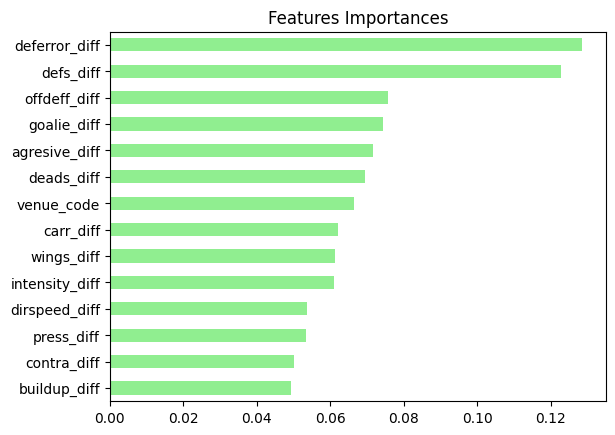

In [131]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)

model,pred,info=make_predictions(splited ,rf,feature_names,plot_imp=True,plot_roc=False)

[('standardscaler', StandardScaler()), ('svc', SVC(probability=True))]
0.7339449541284404
[[ 38  40]
 [ 18 122]]
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       140
           1       0.68      0.49      0.57        78

    accuracy                           0.73       218
   macro avg       0.72      0.68      0.69       218
weighted avg       0.73      0.73      0.72       218

AUCscore: 0.7993589743589743


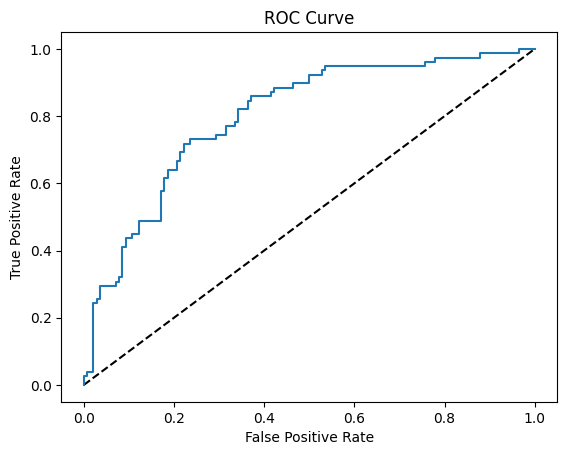

In [140]:
from sklearn.svm import SVC

svm= SVC(probability=True)

# Specify the hyperparameter space
parameters = {'svc__C':[1, 10, 100],
              'svc__gamma':[0.1, 0.01]}

model,pred,info=make_predictions(splited ,svm,feature_names,plot_imp=True,plot_roc=True,scale=True,grid_params=parameters)


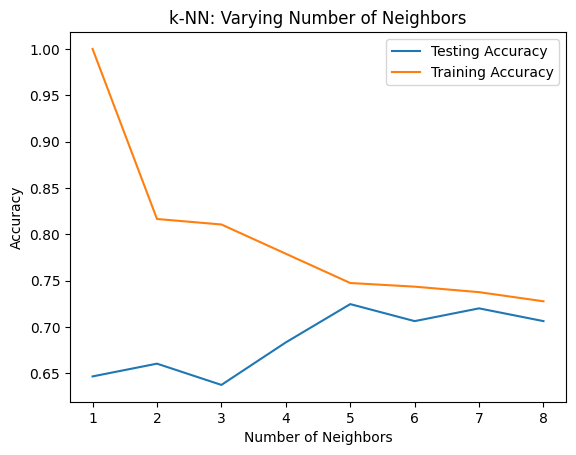

0.7064220183486238
[[ 35  43]
 [ 21 119]]
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       140
           1       0.62      0.45      0.52        78

    accuracy                           0.71       218
   macro avg       0.68      0.65      0.66       218
weighted avg       0.70      0.71      0.69       218

AUCscore: 0.736492673992674


In [141]:
def how_many_neighbours(data):
    X_train, X_test, y_train, y_test = data
    # Setup arrays to store train and test accuracies
    neighbors = np.arange(1, 9)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))

    # Loop over different values of k
    for i, k in enumerate(neighbors):
        # Setup a k-NN Classifier with k neighbors: knn
        knn = KNeighborsClassifier(n_neighbors=k)

        # Fit the classifier to the training data
        knn.fit(X_train,y_train)
        
        #Compute accuracy on the training set
        train_accuracy[i] = knn.score(X_train,y_train)
        #Compute accuracy on the testing set
        test_accuracy[i] = knn.score(X_test, y_test)

    # Generate plot
    plt.title('k-NN: Varying Number of Neighbors')
    plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
    plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
    plt.legend()
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.show()

how_many_neighbours(splited)

# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=6)

model,pred,info=make_predictions(splited ,knn,feature_names,plot_imp=True,plot_roc=False)

[('standardscaler', StandardScaler()), ('logisticregression', LogisticRegression())]
0.7339449541284404
[[ 46  32]
 [ 26 114]]
              precision    recall  f1-score   support

           0       0.78      0.81      0.80       140
           1       0.64      0.59      0.61        78

    accuracy                           0.73       218
   macro avg       0.71      0.70      0.71       218
weighted avg       0.73      0.73      0.73       218

AUCscore: 0.8082417582417583


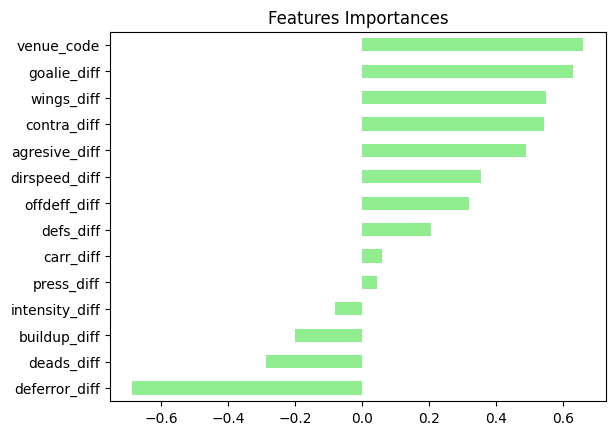

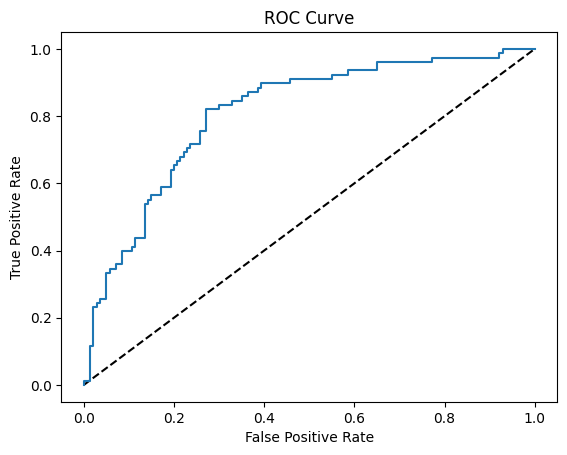

In [150]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lreg=LogisticRegression()

model,pred,info=make_predictions(splited ,lreg,feature_names,plot_imp=True,plot_roc=True,scale=True)

# befroe rolling 0.7236842105263158
# [[110  24]
#  [ 39  55]]


[('standardscaler', StandardScaler()), ('logisticregression', LogisticRegression())]
0.7339449541284404
[[ 39  39]
 [ 19 121]]
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       140
           1       0.67      0.50      0.57        78

    accuracy                           0.73       218
   macro avg       0.71      0.68      0.69       218
weighted avg       0.73      0.73      0.72       218

AUCscore: 0.801007326007326


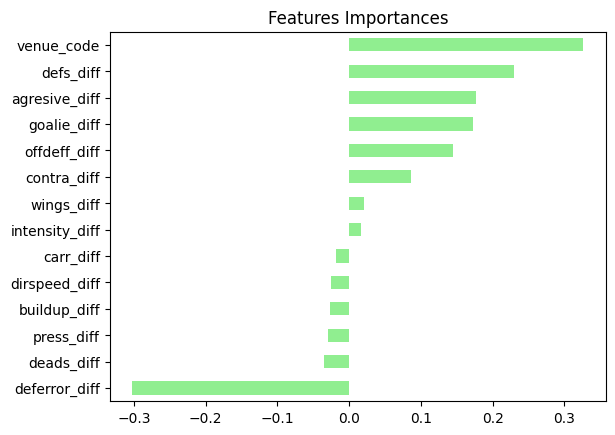

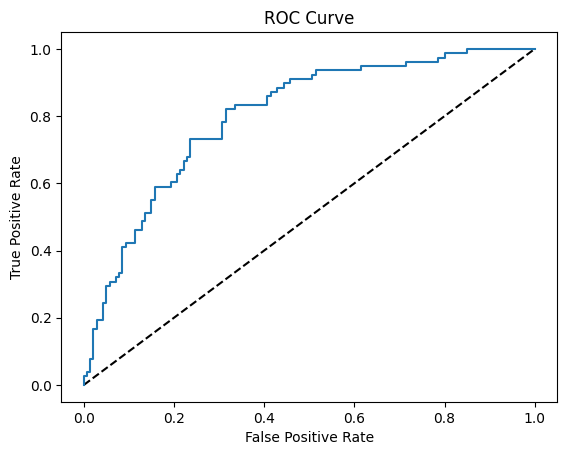

In [153]:
# GridSearch
import warnings
warnings.filterwarnings("ignore")
lreg=LogisticRegression()
# Specify the hyperparameter space
# parameters = {'logisticregression__C': np.logspace(-5, 8, 15)}
parameters = [    
    {'logisticregression__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'logisticregression__C' : np.logspace(-4, 4, 20),
    # 'logisticregression__solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    # 'logisticregression__max_iter' : [100, 1000,2500, 5000]
    }]

model,pred,info=make_predictions(splited ,lreg,feature_names,plot_imp=True,plot_roc=True,scale=True,grid_params=parameters)

# 0.75 {'lreg__C': 0.23357214690901212, 'lreg__penalty': 'l2'}


0.6834862385321101
[[ 42  36]
 [ 33 107]]
              precision    recall  f1-score   support

           0       0.75      0.76      0.76       140
           1       0.56      0.54      0.55        78

    accuracy                           0.68       218
   macro avg       0.65      0.65      0.65       218
weighted avg       0.68      0.68      0.68       218

AUCscore: 0.6731684981684982


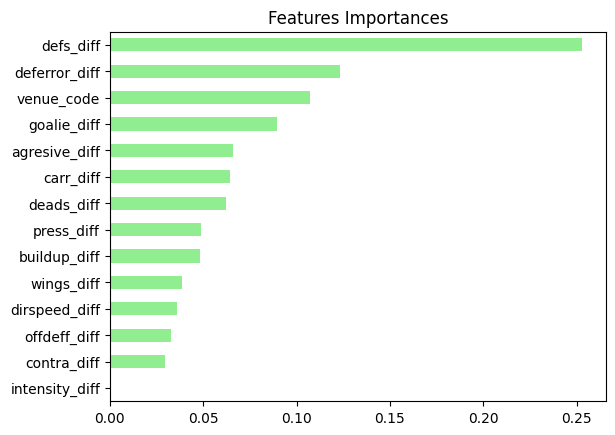

In [154]:
#CART - Classification and Regression Trees 
# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=6, random_state=1, criterion='entropy') #, criterion='gini'

model,pred,info=make_predictions(splited ,dt,feature_names,plot_imp=True,plot_roc=False)


In [155]:
# Import VotingClassifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier

# Instantiate clses
SEED=1 # Set seed for reproducibility
lr = LogisticRegression(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=2)
dt = DecisionTreeClassifier(min_samples_leaf=0.13, random_state=SEED)

# Define the list classifiers
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]

# Instantiate a VotingClassifier vc 
vc = VotingClassifier(estimators=classifiers)     

model,pred,info=make_predictions(splited ,vc,feature_names,plot_imp=True,plot_roc=False)

0.7385321100917431
[[ 41  37]
 [ 20 120]]
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       140
           1       0.67      0.53      0.59        78

    accuracy                           0.74       218
   macro avg       0.72      0.69      0.70       218
weighted avg       0.73      0.74      0.73       218



In [156]:
# Import BaggingClassifier
from sklearn.ensemble import BaggingClassifier

# Instantiate dt
dt = DecisionTreeClassifier(random_state=1)
# 50 drzew z rozna bootsrapowana data glosuje -> tworzy sie 50 tych samych modeli dopasowanych do innej kombincji danych
bc = BaggingClassifier(base_estimator=dt, n_estimators=50, random_state=1, oob_score=True)

model,pred,info=make_predictions(splited ,bc,feature_names,plot_imp=True,plot_roc=False)


0.7064220183486238
[[ 39  39]
 [ 25 115]]
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       140
           1       0.61      0.50      0.55        78

    accuracy                           0.71       218
   macro avg       0.68      0.66      0.67       218
weighted avg       0.70      0.71      0.70       218

AUCscore: 0.7391483516483517
OOBscore: 0.6804733727810651


0.6559633027522935
[[ 40  38]
 [ 37 103]]
              precision    recall  f1-score   support

           0       0.73      0.74      0.73       140
           1       0.52      0.51      0.52        78

    accuracy                           0.66       218
   macro avg       0.62      0.62      0.62       218
weighted avg       0.65      0.66      0.66       218

AUCscore: 0.6745421245421246


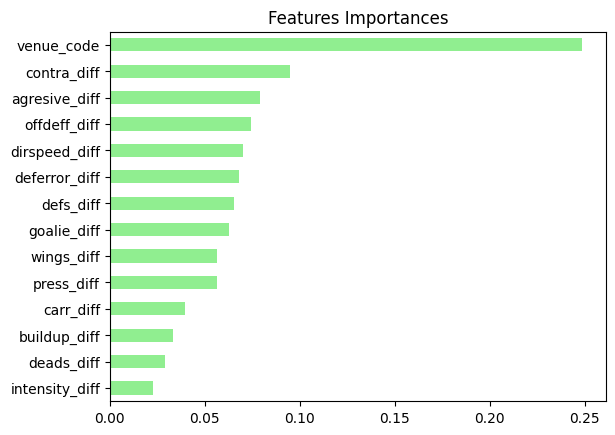

In [157]:
# Import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# Instantiate dt
dt = DecisionTreeClassifier(max_depth=2, random_state=1)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=200, random_state=1)

model,pred,info=make_predictions(splited ,ada,feature_names,plot_imp=True,plot_roc=False)


  File "c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\krawc\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 546, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\krawc\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1022, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\krawc\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1491, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


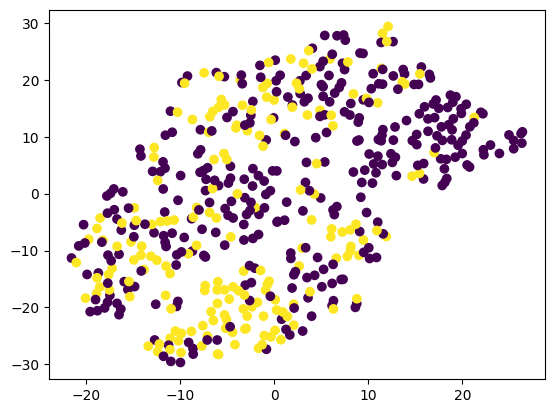

In [ ]:
def plot_tsne(data):
    X_train, X_test, y_train, y_test = data

    # Import TSNE
    from sklearn.manifold import TSNE

    # Create a TSNE instance: model
    model = TSNE(learning_rate=200)
    # Apply fit_transform to samples: tsne_features
    tsne_features = model.fit_transform(X_train)

    # Select the 0th feature: xs
    xs = tsne_features[:,0]
    # Select the 1st feature: ys
    ys = tsne_features[:,1]

    # Scatter plot, coloring by variety_numbers
    plt.scatter(xs,ys,c=y_train)
    plt.show()
plot_tsne(splited)

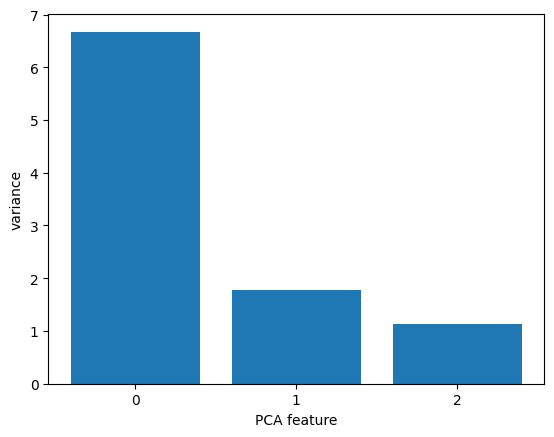

(507, 14)
(507, 3)


,goalie_diff,defs_diff,offdeff_diff,intensity_diff,dirspeed_diff,deads_diff,press_diff,contra_diff,buildup_diff,carr_diff,wings_diff,agresive_diff,deferror_diff,venue_code
PC1,-0.271976,-0.295103,-0.276464,-0.372653,0.275564,0.373606,-0.289317,-0.218420,-0.347617,0.192748,0.288653,0.032584,0.185025,-0.010290
PC2,0.295633,-0.113236,0.182962,0.065373,-0.357841,-0.097581,-0.255882,-0.223501,0.084843,0.436133,0.360891,-0.526855,-0.042612,-0.044560
PC3,0.111615,0.353711,0.206628,-0.087430,0.111546,0.044441,-0.189298,-0.428042,-0.159785,-0.111726,0.151872,0.265356,-0.656784,0.125549


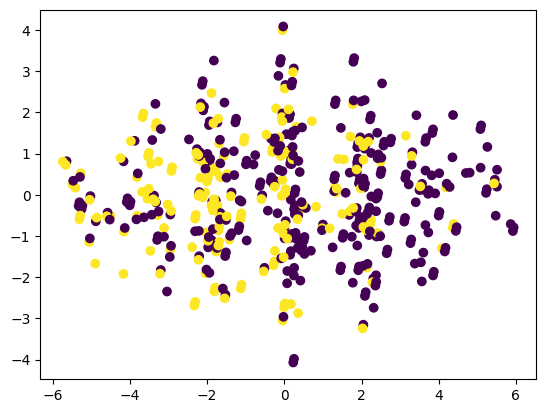

In [ ]:
def plot_pca(data,n_components=3):
    X_train, X_test, y_train, y_test = data
    # how many intrinsic dimensions you have to set n_components - idealy to intrinsic dimention


    from sklearn.decomposition import PCA

    # Create scaler: scaler
    scaler = StandardScaler()
    # Create a PCA instance: pca
    if n_components:
        pca = PCA(n_components=n_components)
    else:
        pca = PCA()

    # Create pipeline: pipeline
    pipeline = make_pipeline(scaler,pca)
    # Fit the pipeline to 'samples'
    pipeline.fit(X_train)

    # Transform the scaled samples: pca_features
    pca_features = pipeline.transform(X_train)


    # Plot the explained variances
    features = range(pca.n_components_)
    plt.bar(features, pca.explained_variance_)
    plt.xlabel('PCA feature')
    plt.ylabel('variance')
    plt.xticks(features)
    plt.show()

    # Print the shape of pca_features
    print(X_train.shape)
    print(pca_features.shape)

    # This information is included in the pca attribute: components_. As described in the documentation, 
    # pca.components_ outputs an array of [n_components, n_features], 
    # so to get how components are linearly related with the different features you have to:
    #wychodzi na to ze PC sa skorelowane z kazdym feature i sa ich oszacowaniem, wiec nie wiadomo z ktorego zrezygnowac
    # Dump components relations with features:
    display(pd.DataFrame(pca.components_,columns=feature_names,index = [f'PC{x}' for x in range(1,n_components+1)]))

    # Select the 0th feature: xs
    xs = pca_features[:,0]
    # Select the 1st feature: ys
    ys = pca_features[:,1]
    # Scatter plot, coloring by variety_numbers
    plt.scatter(xs,ys,c=y_train)
    plt.show()
    
plot_pca(splited)

In [ ]:
# export_model(clf,'modelname')

fin=append_preds(matches2,full,feature_names,model)
fin
# fin.to_csv('match_w_pred_2223diff.csv')

,team,date,time,round,day,venue,result,gf,ga,opponent,target,venue_code,y_pred,y_prob
0,Arsenal,2022-08-05,20:00:00,Matchweek 1,Fri,Away,W,2,0,Crystal Palace,1,0,0,0.048381
1,Arsenal,2022-08-13,15:00:00,Matchweek 2,Sat,Home,W,4,2,Leicester City,1,1,0,0.096144
2,Arsenal,2022-08-20,17:30:00,Matchweek 3,Sat,Away,W,3,0,Bournemouth,1,0,0,0.053366
3,Arsenal,2022-08-27,17:30:00,Matchweek 4,Sat,Home,W,2,1,Fulham,1,1,0,0.032635
4,Arsenal,2022-08-31,19:30:00,Matchweek 5,Wed,Home,W,2,1,Aston Villa,1,1,0,0.064698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,Wolves,2023-04-29,15:00:00,Matchweek 34,Sat,Away,L,0,6,Brighton,0,0,0,0.269399
756,Wolves,2023-05-06,15:00:00,Matchweek 35,Sat,Home,W,1,0,Aston Villa,1,1,1,0.631133
757,Wolves,2023-05-13,15:00:00,Matchweek 36,Sat,Away,L,0,2,Manchester Utd,0,0,0,0.289782
758,Wolves,2023-05-20,15:00:00,Matchweek 37,Sat,Home,D,1,1,Everton,0,1,0,0.450752
